# Preparing a Zarr dataset for our CNN training

**Author:** Eli Holmes (NOAA)

**Goal:** an xarray Dataset on a Google Bucket

For fitting our CNN model with TensorFlow, we want an xarray Dataset with our predictors and response variables. We need the variables to be chunked dask arrays. The time dimension should be named `time` and grid `lat` and `lon`, for use in my fitting code. We also need an ocean mask.

I will put it in a public Google Cloud Bucket for easy access and sharing.

### Prep and wrangle the data

* Subset to a smaller spatial region
* Subset to only the variables I need
* Get rid of days with many NaNs in the response variable
* Add a seasonal term
* Add an ocean mask
* Normalize the input variables

The final xarray will have this

- time, lat, lon
- sst, so, topo (SST, salinity, bathymetry)
- y (gapfree chlorophyll)
- ocean_mask
- sin, cos

### Save to a cloud-optimized format

Save in Zarr format. Why Zarr? It is a standard ML-optimized format for gridded data.

* Chunked & lazy loading: Keeps your Dask chunking intact.
* Efficient: Only loads the data you need into memory.
* Parallel IO: Works great with Dask for scalable access.
* Flexible: Plays well with training pipelines in TensorFlow or PyTorch via prefetching or conversion.

Put in a Google Cloud Bucket. Why? Easy access for a big dataset.
  
## Load the libraries that we need


In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

## Load data

In [2]:
data_xr = xr.open_zarr("~/shared/mind_the_chl_gap/IO.zarr")
data_xr

<xarray.Dataset> Size: 66GB
Dimensions:                       (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat                           (lat) float32 708B 32.0 31.75 ... -11.75 -12.0
  * lon                           (lon) float32 964B 42.0 42.25 ... 101.8 102.0
  * time                          (time) datetime64[ns] 129kB 1979-01-01 ... ...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 686MB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Basic data cleaning

Slice to a smaller spatial region, remove any all NA days.

### Select

In [3]:
# predictors
pred_var = ["sst", "so", "topo"]
# response variable; this is what we are predicting
resp_var = "CHL_cmes-gapfree"
# our mask for land
land_mask = "CHL_cmes-land"

data_xr = data_xr[pred_var + [resp_var, land_mask]]
data_xr = data_xr.rename({resp_var: "y", land_mask: "land_mask"})
data_xr

<xarray.Dataset> Size: 8GB
Dimensions:    (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat        (lat) float32 708B 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon        (lon) float32 964B 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time       (time) datetime64[ns] 129kB 1979-01-01 1979-01-02 ... 2022-12-31
Data variables:
    sst        (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    so         (time, lat, lon) float32 3GB dask.array<chunksize=(500, 177, 241), meta=np.ndarray>
    topo       (lat, lon) float64 341kB dask.array<chunksize=(177, 241), meta=np.ndarray>
    y          (time, lat, lon) float32 3GB dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    land_mask  (lat, lon) uint8 43kB dask.array<chunksize=(177, 241), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

### Slice

In [4]:
# slice to a lat/lon segment
data_xr = data_xr.sel(lat=slice(35, -5), lon=slice(45,90))

### Cull days with no y data (all NaN)

In [5]:
# remove years with no CHL data; these will be all NaN
# This includes all the early years
all_nan_y = np.isnan(data_xr["y"]).all(dim=["lon", "lat"]).compute()  
data_xr = data_xr.sel(time=(all_nan_y == False))
data_xr

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 9207, lat: 149, lon: 181)
Coordinates:
  * lat        (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon        (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time       (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    sst        (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    so         (time, lat, lon) float32 993MB dask.array<chunksize=(487, 149, 181), meta=np.ndarray>
    topo       (lat, lon) float64 216kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    y          (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    land_mask  (lat, lon) uint8 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

### Double-check time sorted

In [6]:
data_xr = data_xr.sortby("time")

## Create an ocean mask

We want an ocean mask but we have a land (land=True) mask that includes inland lakes, which are not ocean.

In [7]:
# Fix the land mask to True/False; ocean = True
data_xr["land_mask"] = data_xr["land_mask"] == 0 
# Mark where SST is always missing (likely lakes)
invalid_ocean = np.isnan(data_xr["sst"]).all(dim="time") 
# Update land_mask: set to False (i.e. land/lake) where SST is always NaN
data_xr["land_mask"] = data_xr["land_mask"].where(~invalid_ocean, other=False)
# Rename our mask to ocean_mask
data_xr = data_xr.rename({"land_mask": "ocean_mask"})

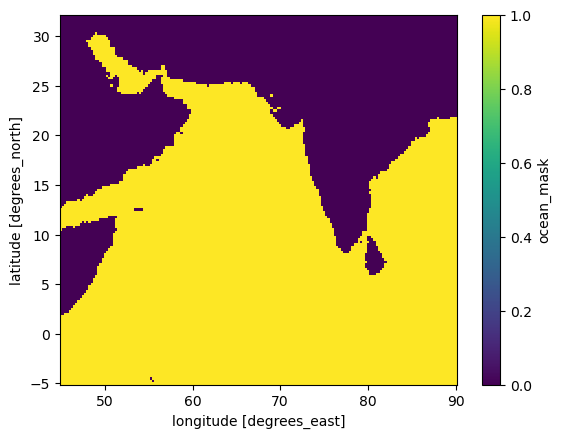

In [14]:
# Check our land mask
data_xr["ocean_mask"].plot();

## log our response

In [8]:
data_xr["y"] = np.log(data_xr["y"])

### Replace data over land with NaN

Make sure any variables over land are NaN so no lake data.

In [9]:
for var in pred_var + ["y"]:
    var_data = data_xr[var]
    dims = var_data.dims  # Save original order
    ocean = data_xr["ocean_mask"]

    # Broadcast ocean mask to var_data shape if needed
    if ocean.dims != var_data.dims:
        ocean = ocean.broadcast_like(var_data)

    # Apply mask and restore dimension order
    filled = xr.where(ocean, var_data, np.nan)
    filled = filled.transpose(*dims)

    data_xr[var] = filled

In [10]:
data_xr.sizes

Frozen({'time': 9207, 'lat': 149, 'lon': 181})

## Normalize numerical predictor variables

This is critical for allowing the model to learn the spatial patterns.

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `sst`          | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `so`           | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `sin_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `cos_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `ocean_mask`   | ✅ Varies by lat/lon     | ❌ Static           | Binary (0=land, 1=ocean), do not normalize |
| `y` (response) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, maybe normalize  |


In [10]:
# Process numerical variables
for var in pred_var:
    arr = data_xr[var]
    dims = arr.dims  # Save original dim order

    mean = arr.mean()
    std = arr.std()

    standardized = (arr - mean) / (std + 1e-8)
    standardized = standardized.transpose(*dims)  # Restore original order

    data_xr[var] = standardized

In [12]:
data_xr.sizes

Frozen({'time': 9207, 'lat': 149, 'lon': 181})

## Should we normalize y?

We have already logged CHL so the response is fairly bell-shaped and near 0, but the spatial variance is very different across spatial areas (20x + differences) then we need to deal with that.

We have approximately 3x range so we will leave the response alone. This will make working with predictions easier.

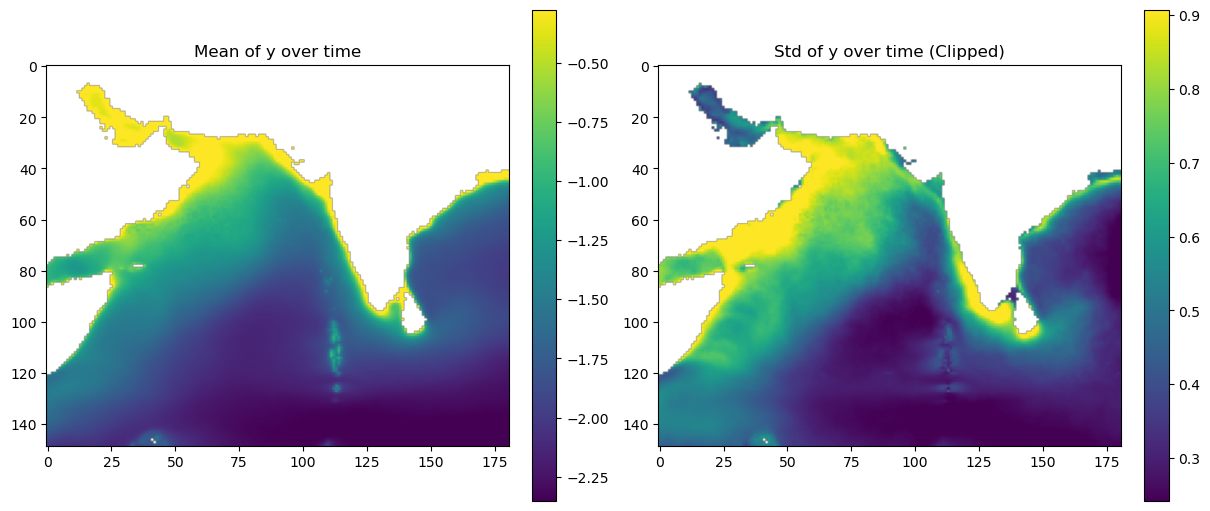

In [45]:
y = data_xr['y']

# Mean and std across time for each (lat, lon)
y_mean_map = y.mean(dim='time')
y_std_map = y.std(dim='time')

# Get the 5 and 95% ranges
vmin_std = np.nanpercentile(y_std_map, 5)
vmax_std = np.nanpercentile(y_std_map, 95)
vmin_mean = np.nanpercentile(y_mean_map, 5)
vmax_mean = np.nanpercentile(y_mean_map, 95)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Mean
im0 = axs[0].imshow(y_mean_map, origin='upper', cmap='viridis',
                    vmin=vmin_mean, vmax=vmax_mean)
axs[0].set_title('Mean of y over time')
plt.colorbar(im0, ax=axs[0])

# Std
im1 = axs[1].imshow(y_std_map, origin='upper', cmap='viridis',
                    vmin=vmin_std, vmax=vmax_std)
axs[1].set_title('Std of y over time (Clipped)')
plt.colorbar(im1, ax=axs[1])

plt.show()

## Add season as a sinusoidal

In the Indian Ocean, the chlorophyll blooms are very seasonal. We will improve the model by including season in our model.

In [11]:
import numpy as np
import dask.array as da
import pandas as pd
import xarray as xr

def add_seasonal_time_features(dataset):
    """
    Adds sin_time and cos_time features to an xarray Dataset.
    These represent the seasonal cycle (day of year) and match the chunking of an existing variable.
    """
    # Convert time coordinate to pandas datetime
    time = pd.to_datetime(dataset['time'].values)

    # Day-of-year in radians
    day_of_year = time.dayofyear.to_numpy()
    day_rad = 2 * np.pi * (day_of_year / 365.25)

    # Compute sin and cos
    # Since day_sin is constant across space, 
    # you first reshape it to (time, 1, 1). 
    # Then you can broadcast it across all lat/lon values:
    day_sin = np.sin(day_rad).astype(np.float32)[:, np.newaxis, np.newaxis]
    day_cos = np.cos(day_rad).astype(np.float32)[:, np.newaxis, np.newaxis]

    # Wrap in Dask arrays
    sin_time = da.from_array(day_sin)
    cos_time = da.from_array(day_cos)

    # Broadcast across the lat/lon space
    shape = dataset['sst'].shape
    sin_time = da.broadcast_to(sin_time, shape)
    cos_time = da.broadcast_to(cos_time, shape)

    # Match chunking of a reference variable (e.g., sst)
    sin_time = sin_time.rechunk(dataset['sst'].data.chunks)
    cos_time = cos_time.rechunk(dataset['sst'].data.chunks)

    # Add to dataset
    return dataset.assign(
        sin_time=(("time", "lat", "lon"), sin_time),
        cos_time=(("time", "lat", "lon"), cos_time)
    )


In [12]:
# Add season
data_xr = add_seasonal_time_features(data_xr)
data_xr

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 9207, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    sst         (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    so          (time, lat, lon) float32 993MB dask.array<chunksize=(487, 149, 181), meta=np.ndarray>
    topo        (lat, lon) float64 216kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    y           (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
    cos_time    (time, lat, lon) float32 993MB dask.array<chunksize=(99, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

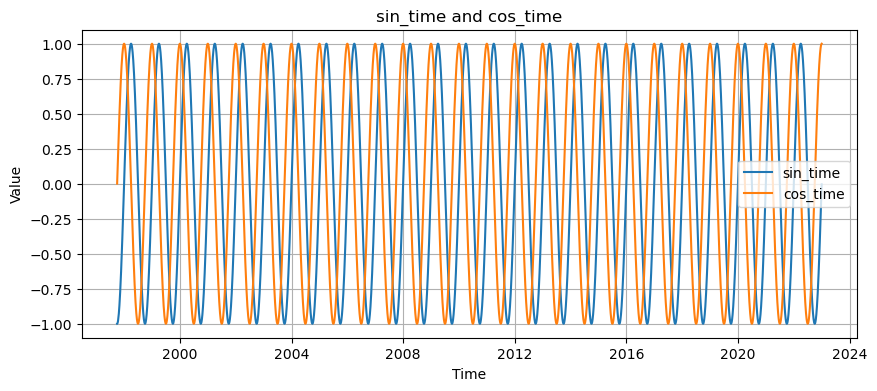

In [107]:
# Let's check that sin and cos look good
import matplotlib.pyplot as plt

# Pick a grid point
ilat, ilon = 50, 90

# Extract time series
sin_series = data_xr['sin_time'][:, ilat, ilon].values
cos_series = data_xr['cos_time'][:, ilat, ilon].values
time = data_xr['time'].values

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time, sin_series, label='sin_time')
plt.plot(time, cos_series, label='cos_time')
plt.legend()
plt.title(f'sin_time and cos_time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Re-chunk to optimize for CNN

Square lat/lon chunks are better and we will use 100 day chunks to minimize the number of IO calls.

In [13]:
# Re-chunk for efficient training
data_xr = xr.Dataset({
    var: data_xr[var].chunk({
        dim: chunk for dim, chunk in {'time': 100, 'lat': 64, 'lon': 64}.items()
        if dim in data_xr[var].dims
    })
    for var in data_xr.data_vars
})
# Clear meta data otherwise, will get error on trying to write the Zarr
for var in data_xr.variables:
    data_xr[var].encoding.pop("chunks", None)
data_xr

<xarray.Dataset> Size: 5GB
Dimensions:     (lat: 149, lon: 181, time: 9207)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    sst         (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    topo        (lat, lon) float64 216kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    cos_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

## Make vars float32 since TensorFlow is going to expect that

In [14]:
data_xr["ocean_mask"] = data_xr["ocean_mask"].astype("float32")
data_xr["topo"] = data_xr["topo"].astype("float32")

## Upload the Zarr file to a Google bucket


In [17]:
# Auth for GCS
import gcsfs
fs = gcsfs.GCSFileSystem(token="/home/jovyan/.config/gcloud/application_default_credentials.json")
zarr_path = "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial/"
data_xr.to_zarr(
    zarr_path,
    storage_options={"token": "/home/jovyan/.config/gcloud/application_default_credentials.json"},
    mode="w",
    consolidated=True
)
print("Zarr uploaded to GCS!")

Zarr uploaded to GCS!


## Test the upload

In [16]:
# first suppress noisy warnings
import warnings
import re

# Suppress the specific GCP user credential quota project warning
warnings.filterwarnings(
    "ignore",
    message="Your application has authenticated using end user credentials from Google Cloud SDK without a quota project.",
    category=UserWarning,
    module="google.auth._default"
)

### Read in file

In [19]:
# test
import xarray as xr
ds = xr.open_zarr("gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial", consolidated=True)
ds

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 9207, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    cos_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    ocean_mask  (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sst         (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    topo        (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

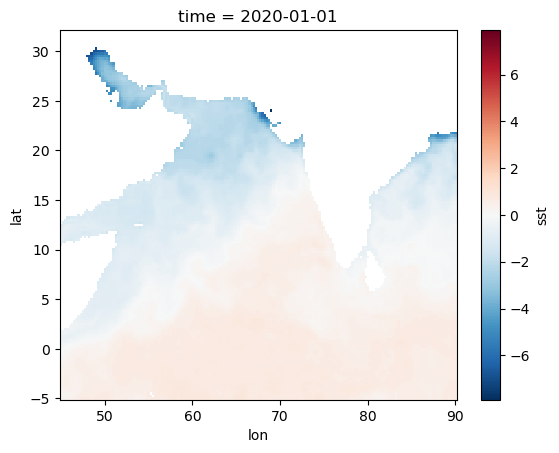

In [23]:
# test plot
ds.sst.sel(time="2020-01-01").plot()

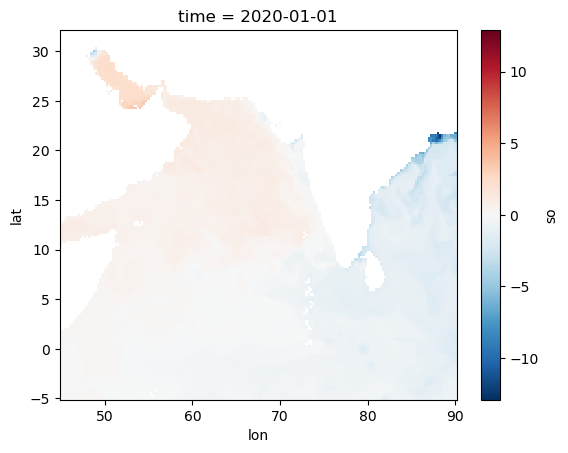

In [24]:
# test plot
ds.so.sel(time="2020-01-01").plot()

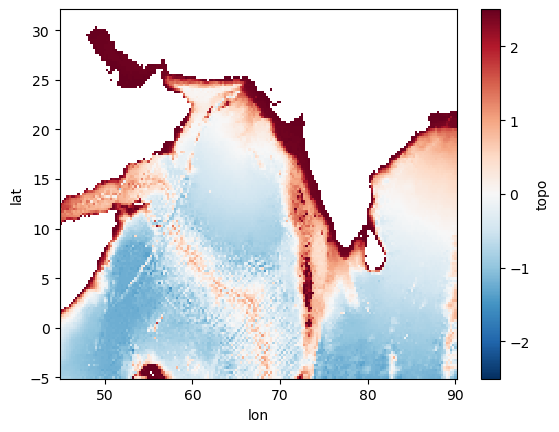

In [26]:
# test plot
ds.topo.plot()

## Summary

We have data for fitting our CCN in the cloud in a Google bucket. It has the key features that we need:

- our predictor variables, normalized to mean 0 and variance 1
- our seasonal indicator variables, not normalized
- our response variable, logged
- an ocean mask to tell the model what parts of image to ignore
- consistently chunked data so we don't IO more data than we need at each step